In [91]:
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional,SimpleRNN
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZED\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
vocab_size = 5000
embedding_dim = 64

oov_tok = '<OOV>' #  Out of Vocabulary
training_portion = 0.8

In [93]:
articles = []
labels = []

with open("tmdb_5000_movies.csv", 'r',encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)


In [94]:
len(labels),len(articles)

(4803, 4803)

In [95]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

In [96]:
print('train_articles' ,len(train_articles))
print('train_labels', len(train_labels))
print('validation_articles', len(validation_articles))
print('validation_labels', len(validation_labels))

train_articles 3842
train_labels 3842
validation_articles 961
validation_labels 961


In [97]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [98]:
word_index




{'<OOV>': 1,
 'id': 2,
 'name': 3,
 '18': 4,
 'drama': 5,
 '35': 6,
 'comedy': 7,
 '53': 8,
 'thriller': 9,
 '28': 10,
 'action': 11,
 '12': 12,
 'adventure': 13,
 '10749': 14,
 'romance': 15,
 '80': 16,
 'crime': 17,
 '10751': 18,
 'family': 19,
 '878': 20,
 'science': 21,
 'fiction': 22,
 '14': 23,
 'fantasy': 24,
 '27': 25,
 'horror': 26,
 '9648': 27,
 'mystery': 28,
 '16': 29,
 'animation': 30,
 '36': 31,
 'history': 32,
 '10402': 33,
 'music': 34,
 '10752': 35,
 'war': 36,
 '37': 37,
 'western': 38,
 '99': 39,
 'documentary': 40,
 '10769': 41,
 'foreign': 42,
 '10770': 43,
 'tv': 44,
 'movie': 45}

In [111]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
len(train_sequences)

3842

In [100]:
train_sequences[0]

[2, 10, 3, 11, 2, 12, 3, 13, 2, 23, 3, 24, 2, 20, 3, 21, 22]

In [101]:
train_padded = pad_sequences(train_sequences, maxlen=max_length,)

In [114]:
len(train_padded),len(train_padded[0])

(3842, 200)

In [103]:
train_padded = train_padded.astype('float32')
training_label_seq = training_label_seq.astype('int32')


In [115]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

In [116]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [122]:
training_label_seq = np.argmax(training_label_seq, axis=1)
validation_label_seq = np.argmax(validation_label_seq, axis=1)


In [123]:
train_labels[0], training_label_seq[0]

('237000000', 0)

In [124]:
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim ))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(6,activation='softmax' ))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)          320000    
                                                                 
 dropout_5 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                                 
Total params: 386822 (1.48 MB)
Trainable params: 386822 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [125]:
import tensorflow as tf

# Define the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Use the new Adam optimizer (no legacy required)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with the correct optimizer, loss, and metrics
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [126]:
num_epochs = 20
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/20
121/121 - 12s - loss: 0.1402 - accuracy: 0.9935 - val_loss: 3.0745e-05 - val_accuracy: 1.0000 - 12s/epoch - 97ms/step
Epoch 2/20
121/121 - 8s - loss: 2.5180e-05 - accuracy: 1.0000 - val_loss: 2.0423e-05 - val_accuracy: 1.0000 - 8s/epoch - 65ms/step
Epoch 3/20
121/121 - 8s - loss: 1.7257e-05 - accuracy: 1.0000 - val_loss: 1.4550e-05 - val_accuracy: 1.0000 - 8s/epoch - 65ms/step
Epoch 4/20
121/121 - 8s - loss: 1.2659e-05 - accuracy: 1.0000 - val_loss: 1.1001e-05 - val_accuracy: 1.0000 - 8s/epoch - 64ms/step
Epoch 5/20
121/121 - 9s - loss: 9.7695e-06 - accuracy: 1.0000 - val_loss: 8.6772e-06 - val_accuracy: 1.0000 - 9s/epoch - 70ms/step
Epoch 6/20
121/121 - 8s - loss: 7.8075e-06 - accuracy: 1.0000 - val_loss: 7.0269e-06 - val_accuracy: 1.0000 - 8s/epoch - 69ms/step
Epoch 7/20
121/121 - 8s - loss: 6.4047e-06 - accuracy: 1.0000 - val_loss: 5.8500e-06 - val_accuracy: 1.0000 - 8s/epoch - 66ms/step
Epoch 8/20
121/121 - 8s - loss: 5.3549e-06 - accuracy: 1.0000 - val_loss: 4.8491e-06 

[2, 10, 3, 11, 2, 12, 3, 13, 2, 23, 3, 24, 2, 20, 3, 21, 22]

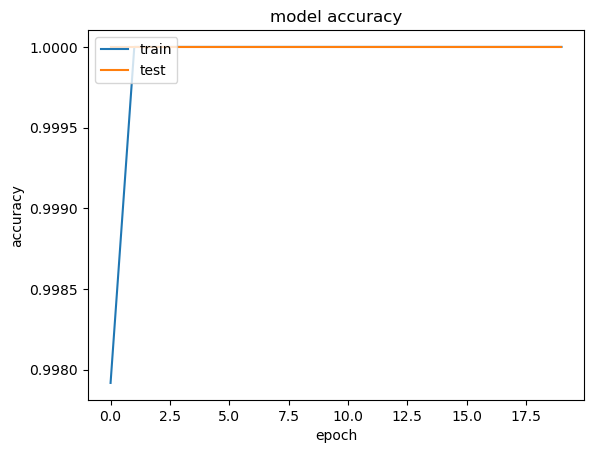

In [112]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()